In [0]:
#!pip install fastai

import numpy as np
import pandas as pd
import requests
#import json
import ast
import os
import gc
import matplotlib.pyplot as plt

#from fastai.vision import *

## Data file (citation)
Data from Dr. McAuley at UCSD (citation)
R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015


In [0]:
# Initial values for the datafile
split_num = 1
file_name = 'metadata_split_' + str(split_num)

## Important: Set variable 'local' to True if running on local machine, False if in cloud

In [0]:
local = False      # this needs to be automated (how?)

### Connect to gs://platform-ai-research/datasets/ProductNet
This is the data bucket - read/write all data files to this location

In [4]:
# Will need to login to access the bucket. The following lines of code do just that
if (not local):
    from google.colab import auth
    auth.authenticate_user()
    
    # List out all the files in the directory (Make sure that we are logged in)
    gs_path = 'platform-ai-research/datasets/ProductNet/'
    !gsutil ls gs://{gs_path}


gs://platform-ai-research/datasets/ProductNet/df_from_splits_1thru6
gs://platform-ai-research/datasets/ProductNet/metadata.feather
gs://platform-ai-research/datasets/ProductNet/metadata_0to500k.json
gs://platform-ai-research/datasets/ProductNet/metadata_split_1
gs://platform-ai-research/datasets/ProductNet/metadata_split_10
gs://platform-ai-research/datasets/ProductNet/metadata_split_10_to_13
gs://platform-ai-research/datasets/ProductNet/metadata_split_11
gs://platform-ai-research/datasets/ProductNet/metadata_split_12
gs://platform-ai-research/datasets/ProductNet/metadata_split_13
gs://platform-ai-research/datasets/ProductNet/metadata_split_14
gs://platform-ai-research/datasets/ProductNet/metadata_split_14_to_19
gs://platform-ai-research/datasets/ProductNet/metadata_split_15
gs://platform-ai-research/datasets/ProductNet/metadata_split_16
gs://platform-ai-research/datasets/ProductNet/metadata_split_17
gs://platform-ai-research/datasets/ProductNet/metadata_split_18
gs://platform-ai-resea

In [0]:
gs_path = 'platform-ai-research/datasets/ProductNet/'

In [6]:
!gsutil ls gs://{gs_path}

gs://platform-ai-research/datasets/ProductNet/df_from_splits_1thru6
gs://platform-ai-research/datasets/ProductNet/metadata.feather
gs://platform-ai-research/datasets/ProductNet/metadata_0to500k.json
gs://platform-ai-research/datasets/ProductNet/metadata_split_1
gs://platform-ai-research/datasets/ProductNet/metadata_split_10
gs://platform-ai-research/datasets/ProductNet/metadata_split_10_to_13
gs://platform-ai-research/datasets/ProductNet/metadata_split_11
gs://platform-ai-research/datasets/ProductNet/metadata_split_12
gs://platform-ai-research/datasets/ProductNet/metadata_split_13
gs://platform-ai-research/datasets/ProductNet/metadata_split_14
gs://platform-ai-research/datasets/ProductNet/metadata_split_14_to_19
gs://platform-ai-research/datasets/ProductNet/metadata_split_15
gs://platform-ai-research/datasets/ProductNet/metadata_split_16
gs://platform-ai-research/datasets/ProductNet/metadata_split_17
gs://platform-ai-research/datasets/ProductNet/metadata_split_18
gs://platform-ai-resea

### Define a few functions
These are used to clean up the data file

In [0]:
# The categories column is a nested list. We need to flatten it
def custom_flat(entry):
    if isinstance(entry[0], list):
        clist = []
        for i in range(len(entry)):
            clist += entry[i]
        return clist
    else:
        return list(entry)

def create_labels(labels):
    s = ', '
    s = s.join(labels)
    return s

def remove_category(df, category):
    print('Current number of Products in dataset =', len(df))
    print('Current number of Unique categories =', len(df.categories.unique()))    
    print('***************Removing Category:', category)
    df = df[~df.categories.str.contains(category)]
    print('Remaining number of Products in dataset =', len(df))
    print('Remaining number of Unique categories =', len(df.categories.unique()))
    return df

### Read in the data

In [0]:
# Read in the data from multiple files, and build the df
main_df = pd.DataFrame()                       # df built by concatenating data from multiple files
df = pd.DataFrame()

for split_num in range(1,7,1):
    data = []
    file_name = 'metadata_split_' + str(split_num)
    print('Reading file................', file_name)
    
    # copy datafile from gs bucket if executing in cloud and file not copied already
    exists = os.path.isfile(file_name)
    if (not exists):
        if (not local):
            # Copy the datafile to the Colab local dir
            remote_file = gs_path + file_name
            !gsutil cp gs://{remote_file} {file_name}
        else: 
            print('File Does Not Exist')
            break
        
    for line in open(file_name, 'r'):          # file_name is defined above
        #data.append(json.loads(line))         # this works for JSON, but our datafiles are not strictly json
        data.append(ast.literal_eval(line))    # JSON but single quotes instead of double
    
    # Convert to dataframe
    df = pd.DataFrame.from_dict(data)

    # Remove columns that we do not need
    df.drop(['brand', 'price', 'related', 'salesRank'], axis=1, inplace=True)

    # Fill in the NaN with empty string
    df.fillna(value='', axis='columns', inplace=True)

    # Flatten the categories list of list so it becomes easier to search
    df.categories = df.categories.apply(np.ravel)
    df.categories = df.categories.apply(custom_flat)
    df.categories = df.categories.apply(create_labels)

    # Remove some products from the dataset
    df = df[~df.categories.str.contains('Books')]
    df = df[~df.categories.str.contains('CDs & Vinyl')]
    df = df[~df.categories.str.contains('Software')]
    df = df[~df.categories.str.contains('Amazon')]
    df = df[~df.categories.str.contains('Movies')]
    df = df[~df.categories.str.contains('Video Games')]

    # Print out a few interesting details
    print('Number of Products in dataset =', len(df))
    print('Number of Unique categories =', len(df.categories.unique()))
    #print('Unique categories are: \n', df.categories.unique())
    
    main_df = main_df.append(df, ignore_index = True)
    df = pd.DataFrame()

print('\nCombined df:')
print('Number of Products in dataset =', len(main_df))
print('Number of Unique categories =', len(main_df.categories.unique()))

Reading file................ metadata_split_1
Number of Products in dataset = 810
Number of Unique categories = 153
Reading file................ metadata_split_2
Number of Products in dataset = 1484
Number of Unique categories = 186
Reading file................ metadata_split_3
Number of Products in dataset = 2606
Number of Unique categories = 326
Reading file................ metadata_split_4
Number of Products in dataset = 21543
Number of Unique categories = 2295
Reading file................ metadata_split_5
Number of Products in dataset = 265682
Number of Unique categories = 14267
Reading file................ metadata_split_6
Number of Products in dataset = 375271
Number of Unique categories = 19895

Combined df:
Number of Products in dataset = 667396
Number of Unique categories = 23624


In [0]:
# Use the following to remove further categories from the dataset
main_df = remove_category(main_df, 'Kindle')

Current number of Products in dataset = 667396
Current number of Unique categories = 23624
***************Removing Category: Kindle
Remaining number of Products in dataset = 667271
Remaining number of Unique categories = 23562


In [0]:
# Create a Label category
main_df['label'] = main_df.categories.str.split(',',1).str[0]

# Fixing some issues
main_df.label.replace(to_replace='Furniture & D&#233;cor', value='Furniture & Decor', inplace=True)

In [0]:
main_df.label.unique()

array(['Clothing', 'Sports & Outdoors', 'Toys & Games', '',
       'Musical Instruments', 'Tools & Home Improvement',
       'Home & Kitchen', 'Health & Personal Care',
       'Cell Phones & Accessories', 'Office Products', 'Electronics',
       'Office & School Supplies', 'Baby', 'Beauty', 'Automotive', 'Arts',
       'Computers', 'All Electronics', 'Pet Supplies',
       'Grocery & Gourmet Food', 'Kitchen & Dining',
       'Industrial & Scientific', 'Appliances', 'All Beauty',
       'Camera & Photo', 'Patio', 'Home Improvement', 'Baby Products',
       'Digital Music', 'MP3 Players & Accessories', 'Car Electronics',
       'Collectibles & Fine Art', 'Purchase Circles', 'GPS & Navigation',
       'Luxury Beauty', 'Magazine Subscriptions', 'Furniture & Decor',
       'Gift Cards Store', 'Sports Collectibles'], dtype=object)

In [0]:
# Write df as a csv file
file_name = 'df_from_splits_1thru6'
main_df.to_csv(file_name)

# Copy file to bucket if not running locally
remote_file = gs_path + file_name
if (not local):
    !gsutil cp {file_name} gs://{remote_file}

Copying file://df_from_splits_1thru6 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/402.4 MiB.                                    


In [0]:
!gsutil ls gs://{gs_path}

gs://platform-ai-research/datasets/ProductNet/df_from_splits_1thru6
gs://platform-ai-research/datasets/ProductNet/metadata_0to500k.json
gs://platform-ai-research/datasets/ProductNet/metadata_split_1
gs://platform-ai-research/datasets/ProductNet/metadata_split_10
gs://platform-ai-research/datasets/ProductNet/metadata_split_10_to_13
gs://platform-ai-research/datasets/ProductNet/metadata_split_11
gs://platform-ai-research/datasets/ProductNet/metadata_split_12
gs://platform-ai-research/datasets/ProductNet/metadata_split_13
gs://platform-ai-research/datasets/ProductNet/metadata_split_14
gs://platform-ai-research/datasets/ProductNet/metadata_split_14_to_19
gs://platform-ai-research/datasets/ProductNet/metadata_split_15
gs://platform-ai-research/datasets/ProductNet/metadata_split_16
gs://platform-ai-research/datasets/ProductNet/metadata_split_17
gs://platform-ai-research/datasets/ProductNet/metadata_split_18
gs://platform-ai-research/datasets/ProductNet/metadata_split_19
gs://platform-ai-rese

In [0]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667271 entries, 0 to 667395
Data columns (total 6 columns):
asin           667271 non-null object
categories     667271 non-null object
description    667271 non-null object
imUrl          667271 non-null object
title          667271 non-null object
label          667271 non-null object
dtypes: object(6)
memory usage: 35.6+ MB


In [0]:
len(main_df.label.unique())

39

`metadata.feather` is a combination of all the `metadata_split` cleaned at the first level, i.e., removed categories that contain `CDs & Vinyl`, `Software`,  `Amazon`, `Movies` and `Video Games`.

In [7]:
!pip install pyarrow
!ls

     |████████████████████████████████| 48.5MB 76.1MB/s 
adc.json  sample_data


In [8]:
!gsutil cp gs://{gs_path}"metadata.feather" .

Copying gs://platform-ai-research/datasets/ProductNet/metadata.feather...
-
Operation completed over 1 objects/3.1 GiB.                                      


In [0]:
df = pd.read_feather('metadata.feather')

In [10]:
# remove empty strings
df = df[df.categories != '']

df[df.categories.str.split(',',1).str[0] == ''].head()

,asin,categories,description,imUrl,title


In [0]:
# Create labels
df['label'] = df.categories.str.split(',',1).str[0]

In [0]:
# Remove categories that are not so useful
remove = ['Digital Music', 'Purchase Circles',
          'Magazine Subscriptions', 'Kindle Store', 'Gift Cards Store',
          'Buy a Kindle', 'Amazon Instant Video', 'Classical', 'Rock', 'Folk', 'Jazz', 'International',
          'Alternative Rock', 'Blues', 'Dance & Electronic', 'Pop',
          'Miscellaneous', 'Christian', 'Country', "Children's Music", 'R&B',
          'Broadway & Vocalists', 'Rap & Hip-Hop', 'Classic Rock',
          'Hard Rock & Metal', 'New Age', 'Wine', 'Latin Music', 'Davis',
          'Gospel', 'Gift Cards', 'Publishers', 'Apps for Android',
          'Appstore for Android', 'Microsoft', 'All Credit Cards',
          'Collectible Coins', 'Celebrate your Birthday with Nickelodeon',
          'Entertainment', 'Amazon Coins', 'Amazon Fire TV']

df = df[~df.label.isin(remove)]

In [30]:
df.label.replace(to_replace='Furniture & D&#233;cor', value='Furniture & Decor', inplace=True)

df.head()

,asin,categories,description,imUrl,title,label
0,0000037214,"Clothing, Shoes & Jewelry, Girls, Clothing, Sh...",,http://ecx.images-amazon.com/images/I/31mCncNu...,Purple Sequin Tiny Dancer Tutu Ballet Dance Fa...,Clothing
1,0000032069,"Sports & Outdoors, Other Sports, Dance, Clothi...",,http://ecx.images-amazon.com/images/I/51EzU6qu...,Adult Ballet Tutu Cheetah Pink,Sports & Outdoors
2,0000031909,"Sports & Outdoors, Other Sports, Dance",High quality 3 layer ballet tutu. 12 inches in...,http://ecx.images-amazon.com/images/I/41xBoP0F...,Girls Ballet Tutu Neon Pink,Sports & Outdoors
3,0000032034,"Sports & Outdoors, Other Sports, Dance, Clothi...",,http://ecx.images-amazon.com/images/I/21GNUNIa...,Adult Ballet Tutu Yellow,Sports & Outdoors
4,0000031852,"Sports & Outdoors, Other Sports, Dance",TUtu,http://ecx.images-amazon.com/images/I/51fAmVkT...,Girls Ballet Tutu Zebra Hot Pink,Sports & Outdoors


In [50]:
# See the distribution of the categories
xx = np.array([])
yy = np.array([])
for l in df.label.unique():
    i = len(df[df.label == l])
    print('label = ', l, ' Number of instances = ', str(i))
    xx = np.append(xx,[l])
    yy = np.append(yy,[i])

label =  Clothing  Number of instances =  1435827
label =  Sports & Outdoors  Number of instances =  529408
label =  Toys & Games  Number of instances =  334199
label =  Musical Instruments  Number of instances =  67513
label =  Tools & Home Improvement  Number of instances =  268464
label =  Home & Kitchen  Number of instances =  436927
label =  Health & Personal Care  Number of instances =  262304
label =  Cell Phones & Accessories  Number of instances =  346691
label =  Office Products  Number of instances =  130698
label =  Electronics  Number of instances =  494401
label =  Office & School Supplies  Number of instances =  3316
label =  Baby  Number of instances =  71317
label =  Beauty  Number of instances =  258561
label =  Automotive  Number of instances =  330448
label =  Arts  Number of instances =  115709
label =  Computers  Number of instances =  4450
label =  All Electronics  Number of instances =  7571
label =  Pet Supplies  Number of instances =  110535
label =  Grocery &

In [0]:
xsorted = []

ysorted = sorted(yy, reverse=True)
y_idx = np.argsort(yy)[::-1]

for idx in y_idx:
    xsorted.append(xx[idx])   

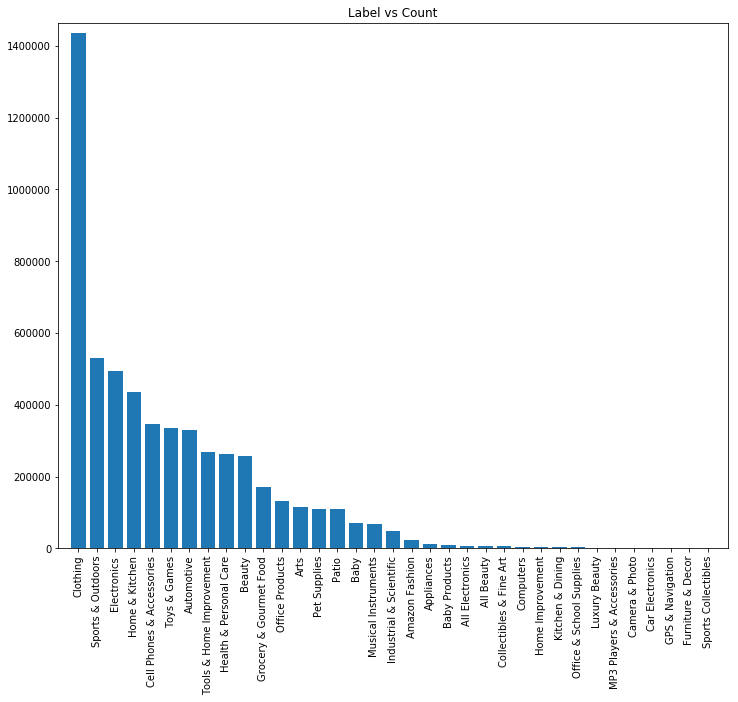

In [61]:
ys = ysorted # [1:] # to remove 'Clothing' as a label
xs = xsorted # [1:] # to remove 'Clothing' as a label

# Plot the distribution
plt.subplots(figsize=(12,10))
plt.bar(range(1,len(ys)+1), ys)
labels = xs
plt.xticks(range(1,len(ys)+1), labels, rotation='vertical')
plt.margins(0.02)
plt.title('Label vs Count')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [62]:
gc.collect()

22986

In [0]:
df = df.reset_index()

df.to_feather('metadata_clean_0513')

In [65]:
!gsutil cp metadata_clean_0513 gs://platform-ai-research/datasets/ProductNet/metadata_clean_0513

Copying file://metadata_clean_0513 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Catching up md5 for file://metadata_clean_0513...
-
Operation completed over 1 objects/3.1 GiB.                                      
